# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 1:
    * Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* inputs/brain-tumor-mri-dataset/mri-images/train
* inputs/brain-tumor-mri-dataset/mri-images/test
* inputs/brain-tumor-mri-dataset/mri-images/validation

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments


---

## Import the regular packages

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
work_dir = os.getcwd()
work_dir

## Set input directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/brain-tumor-mri-dataset/mri-images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set output directory

In [ ]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Set labels

In [ ]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Set image shape

In [ ]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

---

### Number of images in train, test and validation data

In [ ]:
df_freq = pd.DataFrame([])
data_list = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        # Collect data in a list of dictionaries
        data_list.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        })

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

# Convert list of dictionaries to a DataFrame
df_freq = pd.DataFrame(data_list)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image data augmentation

Global Variables and Random Seeds

In [128]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)


Initialize ImageDataGenerator

In [11]:
# Data augmentation and preprocessing
augmented_image_data = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=30,
                                        brightness_range=(0.8, 1.2),
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=15,
                                        zoom_range=0.1,
                                        channel_shift_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="nearest")


Augment training image dataset

In [ ]:
# applying the generator to training data with constant seed
batch_size = 32
train_set = augmented_image_data.flow_from_directory(
                                                    train_path,
                                                    batch_size=batch_size,
                                                    target_size=image_shape[:2],
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=SEED)
train_set.class_indices

Augment validation image dataset

In [ ]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        batch_size=batch_size,
                                                                        target_size=image_shape[:2],
                                                                        class_mode='categorical',
                                                                        shuffle=False,
                                                                        seed=SEED)

validation_set.class_indices

Augment test image dataset

In [ ]:
# applying the generator to testing data with constant seed
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  batch_size=batch_size,
                                                                  target_size=image_shape[:2],
                                                                  class_mode='categorical',
                                                                  shuffle=False,
                                                                  seed=SEED)

test_set.class_indices

Plot augmented training image

In [ ]:
# Get a batch of images from the generator
x_batch, y_batch = next(train_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(train_set.class_indices.keys())[np.argmax(y_batch[i])])  # Display the class name
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()



Plot augmented validation images

In [ ]:
# Get a batch of images from the generator
x_batch, y_batch = next(validation_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(validation_set.class_indices.keys())[np.argmax(y_batch[i])])
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


Plot augmented test images

In [ ]:
# Get a batch of images from the generator
x_batch, y_batch = next(test_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(test_set.class_indices.keys())[np.argmax(y_batch[i])])
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


### Save class_indices

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

---

## Model creation

### ML model
Import model packages

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.regularizers import l2

Model

In [25]:
def create_tf_model():
    model = Sequential()
    model.add(Input(shape=image_shape))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5, seed=SEED))
    model.add(Dense(N_TYPES, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
    
    return model

In [ ]:
# Call the function and display the model summary
model = create_tf_model()
model.summary()

In [ ]:
import visualkeras

# Visualize the model
model_str = visualkeras.layered_view(model, legend=True, max_xy=300, legend_text_spacing_offset=20)

plt.figure(figsize=(10, 10))
plt.imshow(model_str)
plt.axis('off')

plt.savefig(f'{file_path}/model_visualization.png', bbox_inches='tight', dpi=150)

plt.show()

plt.close()

Early Stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if loss doesn't keep decreasing.
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=8, restore_best_weights=True, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Increase steps_per_epoch to repeat the dataset more times per epoch
steps_per_epoch = (len(train_set.classes) // batch_size) * 3  # Repeat dataset 3 times per epoch (adjust multiplier as needed)

Fit model for model training

In [ ]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_set,
          callbacks=[early_stop, model_rlr])

saving the


In [44]:
model.save('outputs/v1/brain_tumor_detector.keras')


## Model Performace

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation
Load saved model

In [47]:
from tensorflow.keras.models import load_model

# Reload the model to ensure fresh state
model = load_model('outputs/v1/brain_tumor_detector.keras')

Evaluate model on test set

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // batch_size)
print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f}")

Save evaluation pickle

In [ ]:
# Saving the evaluation results in a dictionary
evaluation = {
    'loss': loss,
    'accuracy': accuracy
}

# Saving the evaluation results using joblib
joblib.dump(value=evaluation, filename="outputs/v1/evaluation.pkl")

## Predict on new data
Load a random image as PIL

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

# Get the next batch from the test generator
batch_images, batch_labels = next(test_set)

# Extract the first image from the batch
image, label = batch_images[3], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test set
class_indices = test_set.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')

# Display the image
array_to_img(image_tensor[0])


## confusion matrix

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step


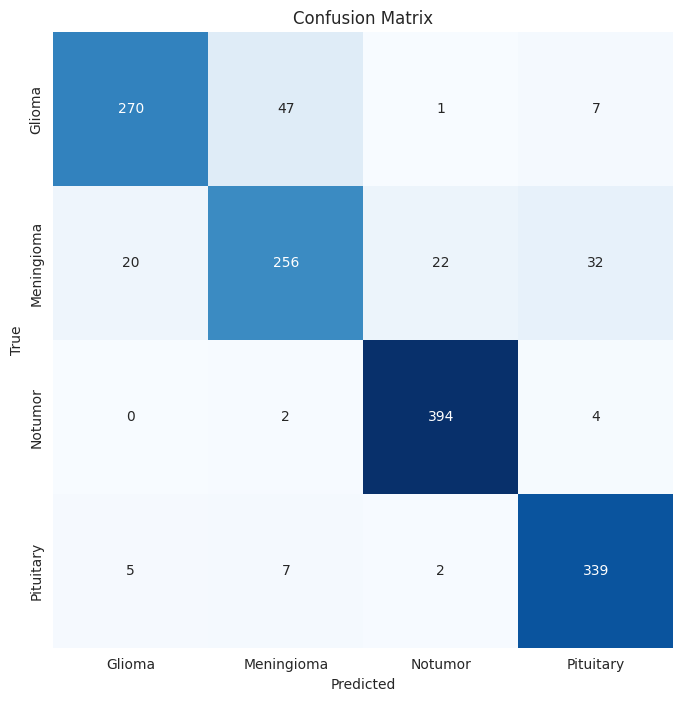

In [132]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

# Make predictions on the test set
predictions = model.predict(test_set, steps=test_set.samples // batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes from test set
true_classes = test_set.classes

# Get class names
class_indices_train_list = list(train_set.class_indices.keys())

# Compute confusion matrix
cm = sklearn_confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')

plt.savefig('outputs/v1/confusion_matrix.png', bbox_inches='tight', dpi=150)

plt.show()



NOTE

---

# Push files to Repo